# Задача.
Обучить модель распознавания текста определять категорию текста (позитивный, негативный, нейтральный и тд.)
0: NEUTRAL
1: POSITIVE
2: NEGATIVE

In [ ]:
pip install -U datasets huggingface_hub fs

In [ ]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd

2025-07-23 11:01:51.389439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753268511.585073      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753268511.641628      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
ds = load_dataset("MonoHime/ru_sentiment_dataset")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 189891
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 21098
    })
})

In [ ]:
ds = ds.remove_columns(['Unnamed: 0'])

In [ ]:
train_labels = ds['train']['sentiment']

In [ ]:
from collections import Counter
counter = Counter(train_labels)
print("Баланс меток в train:", counter)

Баланс меток в train: Counter({1: 90766, 2: 49798, 0: 49327})


Наблюдается дисбаланс классов в таргете. Класс 1 в 2 раза больше остальных классов.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def tokenizer_fn(batch):
  return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

In [ ]:
ds = ds.map(
    tokenizer_fn,
    batched=True,
)

Map:   0%|          | 0/189891 [00:00<?, ? examples/s]

Map:   0%|          | 0/21098 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    num_labels=3
)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
ds = ds.rename_column("sentiment", "labels")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 189891
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 21098
    })
})

In [ ]:
def compute_metrics(pred):
  logits, labels = pred
  preds = np.argmax(logits, axis=-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1': f1}

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=80,
    per_device_eval_batch_size=64,
    learning_rate = 2e-5,
    weight_decay = 0.01,
    do_train=True,                     # включить тренировку
    do_eval=True,                      # включить валидацию
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'f1',
    logging_dir = './logs',
    logging_steps = 100,
    report_to="none"
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds['train'],
    eval_dataset=ds['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

/tmp/ipykernel_36/1293994961.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.461900,0.441614,0.799744,0.797392
2,0.385300,0.435169,0.806001,0.805421
3,0.327300,0.441575,0.810361,0.809699


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=3561, training_loss=0.4151897730368036, metrics={'train_runtime': 7356.9904, 'train_samples_per_second': 77.433, 'train_steps_per_second': 0.484, 'total_flos': 3.747215250434074e+16, 'train_loss': 0.4151897730368036, 'epoch': 3.0})

In [ ]:
eval_result = trainer.evaluate()
print(eval_result)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.4415748417377472, 'eval_accuracy': 0.8103611716750403, 'eval_f1': 0.8096994428349495, 'eval_runtime': 98.7006, 'eval_samples_per_second': 213.758, 'eval_steps_per_second': 1.672, 'epoch': 3.0}


In [ ]:
pred_output = trainer.predict(ds['validation'])
logits = pred_output.predictions
preds = np.argmax(logits, axis = -1)
true_labels = pred_output.label_ids

In [ ]:
print(classification_report(true_labels, preds, digits = 4))

              precision    recall  f1-score   support

           0     0.7141    0.6872    0.7004      5560
           1     0.8290    0.8600    0.8442     10026
           2     0.8704    0.8443    0.8572      5512

    accuracy                         0.8104     21098
   macro avg     0.8045    0.7972    0.8006     21098
weighted avg     0.8095    0.8104    0.8097     21098



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

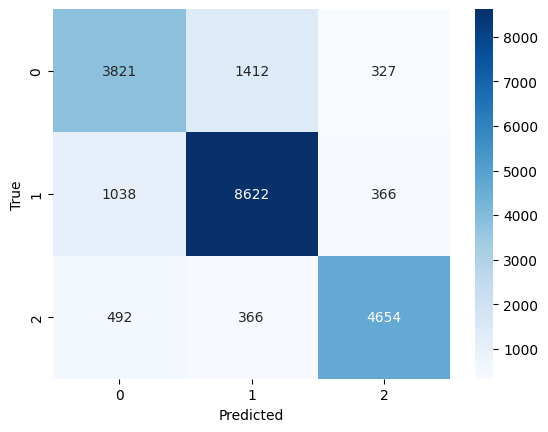

In [ ]:
cm = confusion_matrix(true_labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
trainer.save_model("./results/best_model")      # сохраняет config.json, pytorch_model.bin и т.п.

# 6.2 Сохраняем токенизатор
tokenizer.save_pretrained("./results/best_model")

('./results/best_model/tokenizer_config.json',
 './results/best_model/special_tokens_map.json',
 './results/best_model/vocab.txt',
 './results/best_model/added_tokens.json',
 './results/best_model/tokenizer.json')

In [ ]:
from transformers import pipeline

In [ ]:
classifier = pipeline(
    'text-classification',            # <-- здесь дефис!
    model='./results/best_model',      # папка, где лежат pytorch_model.bin и config.json
    tokenizer='./results/best_model'   # обычно та же папка, что и модель
)

Device set to use cuda:0


In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 189891
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 21098
    })
})

In [ ]:
examples = ds['validation'].select(range(5))

rows = []

for ex in examples:
    text = ex['text']
    pred = classifier(text)[0]
    rows.append({
        'text': text,
        'label_true': ex['labels'],
        'label_pred': pred['label'],
        'score': pred['score']
    })

df_result = pd.DataFrame(rows)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
df_result.head()

,text,label_true,label_pred,score
0,Развода на деньги нет Наблюдаюсь в Лайфклиник ...,1,LABEL_2,0.942853
1,Отель выбрали потому что рядом со стадионом. О...,0,LABEL_1,0.550645
2,"Вылечили Гноился с рождения глазик, в поликлин...",1,LABEL_1,0.998829
3,Хорошее расположение.С вокзала дошли пешком.Но...,0,LABEL_0,0.979015
4,"Отличное месторасположение,прекрасный вид,особ...",1,LABEL_1,0.877908


In [ ]:
custom = [
    "Я в восторге от этой модели!",
    "Это худшее, что я когда-либо видел.",
    'Если честно так все равно на эти ваши модели',
    'Жду релиз уже год. За это время можно было столько моделей придумать. ЖДУ НИ МОГУ конечно'
]
results = classifier(custom)
for text, res in zip(custom, results):
    print(f'Text: {text!r}')
    print(f'-> Predicted: {res["label"]}, (score: {res["score"]:.3f})\n')

Text: 'Я в восторге от этой модели!'
-> Predicted: LABEL_1, (score: 0.802)

Text: 'Это худшее, что я когда-либо видел.'
-> Predicted: LABEL_2, (score: 0.886)

Text: 'Если честно так все равно на эти ваши модели'
-> Predicted: LABEL_0, (score: 0.992)

Text: 'Жду релиз уже год. За это время можно было столько моделей придумать. ЖДУ НИ МОГУ конечно'
-> Predicted: LABEL_0, (score: 0.989)



Наша модель довольно неплохо сработала. Средняя точность предсказания составляет 80%.
Также мы составили несколько своих текстов для проверки работы модели, вцелом модель довольно неплохо определяет "настроение" текста. Удивительно, что на последнем нашем составленном тексте, модель на 96% уверена, что текст нейтрален, хотя это не так. Видимо те паттерны, которые мы использовали в тексте, модель не видела во время обучения - как негативные, отсюда и полученный результат.